In [30]:
import numpy as np
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import layers as L

import matplotlib.pyplot as plt

In [3]:
def make_pairs(images, labels):
	# initialize two empty lists to hold the (image, image) pairs and
	# labels to indicate if a pair is positive or negative
	pairImages = []
	pairLabels = []
	# calculate the total number of classes present in the dataset
	# and then build a list of indexes for each class label that
	# provides the indexes for all examples with a given label
	numClasses = len(np.unique(labels))
	idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
	# loop over all images
	for idxA in range(len(images)):
		# grab the current image and label belonging to the current
		# iteration
		currentImage = images[idxA]
		label = labels[idxA]
		# randomly pick an image that belongs to the *same* class
		# label
		idxB = np.random.choice(idx[label])
		posImage = images[idxB]
		# prepare a positive pair and update the images and labels
		# lists, respectively
		pairImages.append([currentImage, posImage])
		pairLabels.append([1])
		# grab the indices for each of the class labels *not* equal to
		# the current label and randomly pick an image corresponding
		# to a label *not* equal to the current label
		negIdx = np.where(labels != label)[0]
		negImage = images[np.random.choice(negIdx)]
		# prepare a negative pair of images and update our lists
		pairImages.append([currentImage, negImage])
		pairLabels.append([0])
	# return a 2-tuple of our image pairs and labels
	return (np.array(pairImages), np.array(pairLabels))

def plot_training(H, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.title("Training Loss")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)

In [71]:
def build_model(inp):
    def sub_net(i):
        x = L.Conv2D(64, 2, padding="same", activation="relu")(i)
        x = L.MaxPooling2D(pool_size=2)(x)
        x = L.Dropout(0.3)(x)
        return x
    
    x = sub_net(inp)
    x = sub_net(x)
    
    pooled = L.GlobalAveragePooling2D()(x)
    out = L.Dense(32)(pooled)
    
    return tf.keras.Model(inp, out)

In [72]:
inp = L.Input((28,28, 3))
m = build_model(inp)
m.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 28, 28, 3)]       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 64)        832       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 14, 64)        16448     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 7, 7, 64)        

In [163]:
def contrastive_loss(y, preds, margin=1.0):
    y = tf.cast(y, preds.dtype)
    squared = tf.square(preds)
    sqmargin = tf.square(tf.maximum(0.0, margin - preds))
    return tf.reduce_mean(y * squared + (1-y) * sqmargin)

In [164]:
from tensorflow.keras.datasets import mnist

In [165]:
# (trainX, trainY), (testX, testY) = mnist.load_data()
# trainX = trainX / 255.0
# testX = testX / 255.0
# # add a channel dimension to the images
# trainX = np.expand_dims(trainX, axis=-1)
# testX = np.expand_dims(testX, axis=-1)
# # prepare the positive and negative pairs
# print("[INFO] preparing positive and negative pairs...")
# (pairTrain, labelTrain) = make_pairs(trainX, trainY)
# (pairTest, labelTest) = make_pairs(testX, testY)

In [166]:
featureExtractor = build_model(L.Input(trainX.shape[1:]))

In [167]:
def euclidean_distance(vecs) -> float:
    vec1, vec2 = vecs
    return tf.sqrt(tf.reduce_sum(tf.square(vec2-vec1)))

In [168]:
imgA = L.Input(shape=trainX.shape[1:])
imgB = L.Input(shape=trainX.shape[1:])

featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

In [169]:
dist = L.Lambda(euclidean_distance)([featsA, featsB])
siamese = tf.keras.Model(inputs=[imgA, imgB], outputs = dist)

siamese.compile(loss=contrastive_loss, optimizer="adam")

In [170]:
train_dataset = tf.data.Dataset.from_tensors((pairTrain, labelTrain)).batch(64).shuffle(buffer_size=1000).cache()
test_dataset = tf.data.Dataset.from_tensors((pairTest, labelTest)).shuffle(buffer_size=1000).cache()

train_dataset.take(1)

<TakeDataset shapes: ((None, 120000, 2, 28, 28, 1), (None, 120000, 1)), types: (tf.float64, tf.int64)>

In [171]:
# history = siamese.fit(train_dataset.map(lambda r: r[0]), train_dataset.map(lambda r: r[1]), validation_split=0.1, epochs=10)
history = siamese.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:], validation_split=0.1, epochs=5)

Epoch 1/5
3375/3375 [==============================] - 115s 34ms/step - loss: 0.2504 - val_loss: 0.2732
Epoch 2/5
3375/3375 [==============================] - 118s 35ms/step - loss: 0.2497 - val_loss: 0.2673
Epoch 3/5
3375/3375 [==============================] - 121s 36ms/step - loss: 0.2497 - val_loss: 0.2674
Epoch 4/5
3375/3375 [==============================] - 117s 35ms/step - loss: 0.2495 - val_loss: 0.2625
Epoch 5/5
3375/3375 [==============================] - 132s 39ms/step - loss: 0.2495 - val_loss: 0.2693


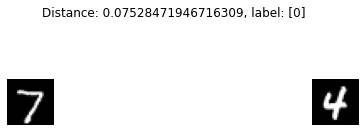

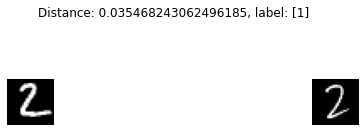

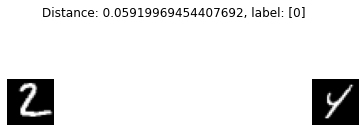

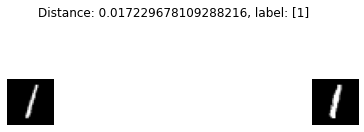

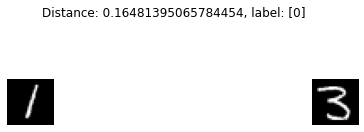

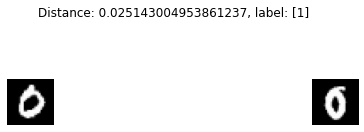

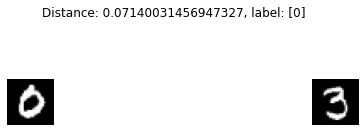

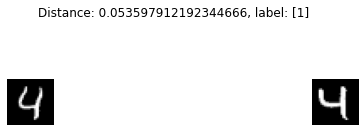

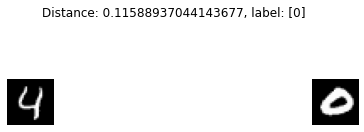

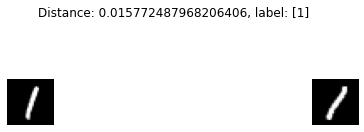

In [197]:
rows = 10

for i in range(1, rows + 1):
    pair, label = np.expand_dims(pairTest[i], axis=0), labelTest[i]
    # use our siamese model to make predictions on the image pair,
    # indicating whether or not the images belong to the same class
    preds = siamese.predict([pair[:, 0], pair[:, 1]])
    pair = np.squeeze(pair)
    proba = preds
    # Contrastive Loss for Siamese Networks with Keras and TensorFlow
    # initialize the figure
    fig = plt.figure("Pair #{}".format(i + 1), figsize=(10, 10))
    plt.suptitle(f"Distance: {proba}, label: {label}")
    # show first image
    ax = fig.add_subplot(row, 2, 1)
    plt.imshow(pair[0], cmap=plt.cm.gray)
    plt.axis("off")
    # show the second image
    ax = fig.add_subplot(row, 2, 2)
    plt.imshow(pair[1], cmap=plt.cm.gray)
    plt.axis("off")
    # show the plot
    plt.show()